In [1]:

! pip install sgmllib3k

  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=e49fee7f540b1b7390cc36c75de26e848ff3a2e303017057fabe452ee53c39f6
  Stored in directory: /Users/mihnea/Library/Caches/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [16]:
#write a autoencoder class and a dataloader class for .png images
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import shutil
import pandas as pd
import random
import transforms

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # output: 16 x 325 x 180
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # output: 32 x 163 x 90
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # output: 64 x 82 x 45
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # output: 128 x 41 x 23
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # output: 256 x 21 x 12
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # output: 128 x 41 x 23
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # output: 64 x 82 x 45
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # output: 32 x 163 x 90
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # output: 16 x 325 x 180
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # output: 3 x 650 x 360
            nn.Sigmoid()  # Using sigmoid to ensure the output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def load_images_from_folder(folder):
    images = []
    count = 0 
    for filename in os.listdir(folder):
        if count == 10:
            break
        data = plt.imread(os.path.join(folder,filename))
        if data is not None:
            data = data[:,:,:3]
            # pad the image into 672x672
            data = np.pad(data, ((0, 672-data.shape[0]), (0, 672-data.shape[1]), (0, 0)), 'constant', constant_values=0)

            images.append(data)
            count += 1
    images = np.array(images)
    images = np.swapaxes(images, 1, 3)
    return images

class ImageDataset(Dataset):
    def __init__(self, folder):
        self.files = [os.path.join(folder, f) for i, f in enumerate(os.listdir(folder)) if f.endswith('.png') and i < 20]
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((672, 672)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = plt.imread(self.files[idx])[:,:,:3]
        image = self.transform(image)
        return image
    
def train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            recon = model(data)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, data, recon),)
    return outputs

def test(model, test_loader):
    criterion = nn.MSELoss()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            recon = model(data)
            loss = criterion(recon, data)
            test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    print('Test Loss:{:.4f}'.format(test_loss))

DATASET_PATH = r"C:\Users\cesar\Downloads\training_images"

In [18]:
from torchvision import transforms

if torch.cuda.is_available():
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_dataset = ImageDataset(DATASET_PATH)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
model = Autoencoder().to(device)
train(model, train_loader, train_loader, num_epochs=50)
test(model, train_loader)
torch.save(model.state_dict(), 'model.pth')
print('Model saved')

Epoch:1, Loss:0.2420
Epoch:2, Loss:0.2412
Epoch:3, Loss:0.2401
Epoch:4, Loss:0.2390
Epoch:5, Loss:0.2361
Epoch:6, Loss:0.2255
Epoch:7, Loss:0.1984
Epoch:8, Loss:0.1920
Epoch:9, Loss:0.1713
Epoch:10, Loss:0.1552
Epoch:11, Loss:0.1369
Epoch:12, Loss:0.1204
Epoch:13, Loss:0.1077
Epoch:14, Loss:0.0964
Epoch:15, Loss:0.0880
Epoch:16, Loss:0.0797
Epoch:17, Loss:0.0719
Epoch:18, Loss:0.0658
Epoch:19, Loss:0.0632
Epoch:20, Loss:0.0607
Epoch:21, Loss:0.0596
Epoch:22, Loss:0.0593
Epoch:23, Loss:0.0564
Epoch:24, Loss:0.0550
Epoch:25, Loss:0.0546
Epoch:26, Loss:0.0543
Epoch:27, Loss:0.0541
Epoch:28, Loss:0.0529
Epoch:29, Loss:0.0507
Epoch:30, Loss:0.0501
Epoch:31, Loss:0.0470
Epoch:32, Loss:0.0451
Epoch:33, Loss:0.0390
Epoch:34, Loss:0.0413
Epoch:35, Loss:0.0397
Epoch:36, Loss:0.0368
Epoch:37, Loss:0.0328
Epoch:38, Loss:0.0264
Epoch:39, Loss:0.0266
Epoch:40, Loss:0.0237
Epoch:41, Loss:0.0238
Epoch:42, Loss:0.0220
Epoch:43, Loss:0.0236
Epoch:44, Loss:0.0219
Epoch:45, Loss:0.0250
Epoch:46, Loss:0.02

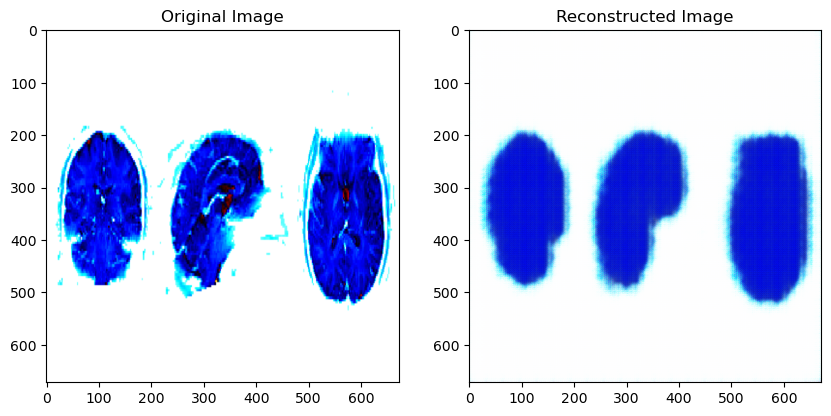

In [20]:
import matplotlib.pyplot as plt

# Load the model
model = Autoencoder()
model.load_state_dict(torch.load('model.pth'))  # Assuming the model is saved under 'model.pth'
model.eval()

# Load a single image from your dataset
dataset = ImageDataset(DATASET_PATH)  # Replace with your image folder path
image = dataset[0]  # Load the first image
image = image.unsqueeze(0)  # Add an extra dimension for batch size

# Pass the image through the model
with torch.no_grad():
    reconstructed = model(image)

# Remove the batch dimension and convert the tensors to numpy arrays
image = image.squeeze(0).permute(1, 2, 0).numpy()
reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed)
plt.title('Reconstructed Image')

plt.show()